# Creating graph datasets for pyTorch Geometric

In [1]:
%pylab inline
%config InlineBackend.figure_format='retina'

from jupyterthemes import jtplot
jtplot.style()

Populating the interactive namespace from numpy and matplotlib


In [8]:
import torch
import igraph
from random import choices, shuffle
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.read.tu import split as unroll

class AssortedGraphDataset( InMemoryDataset ) :

    def __init__( self, root, name='assorted_graphs', transform=None, pre_transform=None ):
        super( AssortedGraphDataset, self ).__init__( root, transform, pre_transform )
        self.name = name
        self.generate()
        
    def generate( self ) :
        
        # build three sets of graphs using different algorithms
        ER_graphs = [ igraph.Graph.Erdos_Renyi( n, 0.1 ) for n in choices( range( 10, 100 ), k=100 ) ]
        BR_graphs = [ igraph.Graph.Barabasi( n, 3 ) for n in choices( range( 10, 100 ), k=100 ) ]
        GR_graphs = [ igraph.Graph.Growing_Random( n, 3 ) for n in choices( range( 10, 100 ), k=100 ) ]
        
        G = igraph.Graph() # initialize an empty graph
        G_indicator = []   # label nodes by graph
        G_label = []       # label graphs by which algorithm was used to make them
        x = []             # node features
        j = 0

        for i,graphset in enumerate( ( ER_graphs, BR_graphs, GR_graphs ) ) :
            for j,g in enumerate( graphset, j ):
                N = len( G.vs )
                n = len( g.vs )
                G.add_vertices( n )
                # offset the edgelist indicies
                G.add_edges( [ ( v1 + N, v2 + N ) for v1, v2 in g.get_edgelist() ] )
                G_indicator.extend( [j]*n )
                x.extend( choices( [[0.]*128,[1.]*128], k=n ) )
            G_label.extend( [i]*len(graphset) )

        # convert lists to tensors
        G_indicator = torch.tensor( G_indicator,      dtype=torch.long )
        G_label     = torch.tensor( G_label,          dtype=torch.long )
        edge_index  = torch.tensor( G.get_edgelist(), dtype=torch.long )
        x           = torch.tensor( x )
        
        train_idx   = [0]*100 + [1]*200
        shuffle( train_idx )
        train_idx   = torch.tensor( train_idx,        dtype=torch.long )
        test_mask   = torch.tensor( [ abs(i-1) for i in train_idx ], dtype=torch.uint8 )
                
        # create the pyTorch Data object
        data = Data( x=x,
                     edge_index=edge_index.t().contiguous(),
                     y=G_label )
        
        data.train_mask = train_idx
        data.test_mask = test_mask
        
        self.data, self.slices = unroll( data, G_indicator )
        
        
    @property
    def raw_file_names( self ) :
        # the raw data is generated, so there aren't any files
        return [ 'fake_filename' ]
        
    @property
    def processed_file_names( self ) :
        return 'data.pt'
    
    def download( self ) :
        # the raw data is generated, so there aren't any files to download
        pass
    
    def process( self ) :
        self.generate()
        torch.save( ( self.data, self.slices ), self.processed_paths[0] )
        
    def __repr__(self):
        return '{}({})'.format(self.name, len(self))

dataset = AssortedGraphDataset( root='/tmp/agd', name='AssortedGraphs' )
dataset.data

Data(edge_index=[2, 50586], test_mask=[300], train_mask=[300], x=[16790, 128], y=[300])

In [9]:
data

AssortedGraphs(298)

In [10]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class Net( torch.nn.Module ) :
    
    def __init__( self ) :
        super( Net, self ).__init__()
        self.conv1 = GCNConv( dataset.num_features, 16 ) #.type( torch.LongTensor )
        self.conv2 = GCNConv( 16, dataset.num_classes ) #.type( torch.LongTensor )
        
    def forward( self, data ):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1( x, edge_index )
        x = F.relu( x )
        x = F.dropout( x, training=self.training )
        x = self.conv2( x, edge_index )
        
        return F.log_softmax( x, dim=1 )

In [11]:
device    = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu' )
model     = Net().to( device )
data      = dataset.to( device )
optimizer = torch.optim.Adam( model.parameters(), lr=0.01, weight_decay=5e-4 )

model.train()

for epoch in range( 200 ) :
    optimizer.zero_grad()
    out  = model( data )
    loss = F.nll_loss( out[ data.train_mask ], data.y[ data.train_mask ] )
    loss.backward()
    optimizer.step()

KeyError: 'train_mask'

In [5]:
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

dataset = Planetoid(root='/tmp/Cora', name='Cora')

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
model.eval()
_, pred = model(data).max(dim=1)
correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Processing...
Done!
Accuracy: 0.8000


In [6]:
dataset.data

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])

(array([324.,  64.,  32.,  29.,  19.,  11.,  10.,   7.,   2.,   2.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

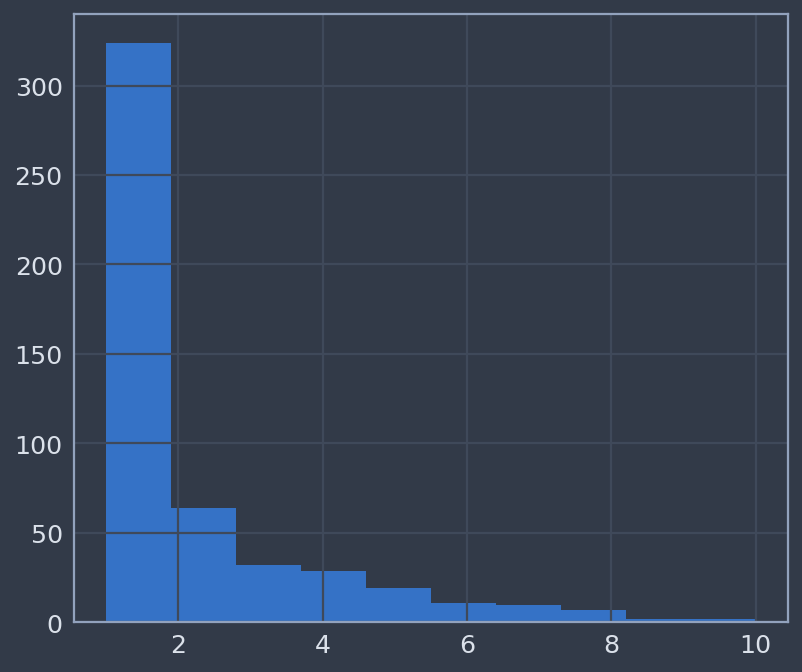

In [12]:
hist([ len( igraph.Graph.Erdos_Renyi( n, 0.1 ).components() ) for n in choices( range( 10, 100 ), k=500 ) ])

In [ ]:
hist([ len( igraph.Graph.Forest_Fire( n, 0.1 ).components() ) for n in random.choices( range( 10, 100 ), k=500 ) ])


In [57]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')

Extracting /tmp/ENZYMES/ENZYMES.zip
Processing...
Done!


In [59]:
dataset.root

'/tmp/ENZYMES'

In [130]:
dataset.data.num_nodes

19580

In [193]:
dataset.data

Data(edge_index=[2, 74564], x=[19580, 3], y=[600])